In [32]:
! pip install --user scipy wordcloud nltk seaborn textblob

#### Import packages

In [33]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [35]:
total_data = pd.read_csv('gdrive/My Drive/projekml/dataset/Datasetresto.csv', encoding="ISO-8859-1")
total_data

,Sentiment,SentimentText
0,1,"My daughter and I enjoyed dinner here for her 21st birthday. We love looking at all the memorabilia in the multiple dining rooms. The food is good, but itâs the atmosphere we enjoy most!"
1,1,We ate at the bar after a show. Nachos and salad with a couple of glasses of wine. Just the right stuff at the right time in a energetic atmosphere. Thank you Duane!
2,1,"I had a very good burger here. The atmosphere is unique but do not expect hard rock music, there were more rap and pop video clips than rock."
3,1,"We booked online beforehand as I went a few years ago and there was quite a wait for walk ins. Food was nice, nothing to boast about but yummy. The staff are friendly and the restaurant is clean. Reasonably priced. Would go again."
4,1,"Not dissapionted at all. It does what it says. Very nice food, drinks & service. We were very well looked after by our server & this is what we have grown to expect from Hard Rock."
...,...,...
1995,0,The service is really bad. Waiters don't even stop when you call them to order something. It took us nearly one hour to get a beer
1996,0,"What a tourist trap --- get a beer but NOTHING else, we waited about 60 minutes for a lukewarm soup and some Weisswurst --- had to wait another 15 minutes to get the privilege to pay - AVOID IF POSSIBLE"
1997,0,Only those who appreciate traditional bavarian Live Music and dancing may enjoy staying here. Two Liters of the Beer caused a horrible Hang-over and not only for me. The Food is less than average.
1998,0,"Rude bunch of people.... Crap service and a complete waist of time. Go somewhere local, people are so much more welcoming."


##### Import Contractions 
##### " can't " >> " can not "

In [36]:
with open('gdrive/My Drive/projekml/assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

In [37]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [38]:
total_data.head()

,Sentiment,SentimentText
0,1,"My daughter and I enjoyed dinner here for her 21st birthday. We love looking at all the memorabilia in the multiple dining rooms. The food is good, but itâs the atmosphere we enjoy most!"
1,1,We ate at the bar after a show. Nachos and salad with a couple of glasses of wine. Just the right stuff at the right time in a energetic atmosphere. Thank you Duane!
2,1,"I had a very good burger here. The atmosphere is unique but do not expect hard rock music, there were more rap and pop video clips than rock."
3,1,"We booked online beforehand as I went a few years ago and there was quite a wait for walk ins. Food was nice, nothing to boast about but yummy. The staff are friendly and the restaurant is clean. Reasonably priced. Would go again."
4,1,"Not dissapionted at all. It does what it says. Very nice food, drinks & service. We were very well looked after by our server & this is what we have grown to expect from Hard Rock."


##### Mengubah kolom yang digunakan menjadi variabel

In [39]:
review = total_data.columns.values[1]
sentiment = total_data.columns.values[0]
review, sentiment

('SentimentText', 'Sentiment')

In [40]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      2000 non-null   int64 
 1   SentimentText  2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<br/>

# 1)  Preprocessing

* **Mengubah semua review menjadi huruf kecil**
* **Menghapus tanda baca, angka, dan karakter khusus**
* **Mengubah lebih dari 2 pengulangan huruf menjadi 2 huruf (contoh (wooooooow --> woow))**
* **Menghapus spasi lebih**
* **Mengubah emoji**
* **Menangani kata-kata yang contractions**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **Spelling correction**
* **Tokenization**
* **Menghapus Stop words**
* **Text Normalization Lemmatization**

##### Mendefinisikan fungsi untuk klasifikasi emoji

In [41]:
def emoji(review):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    review = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', review)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    review = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', review)
    # Love -- <3, :*
    review = re.sub(r'(<3|:\*)', ' positiveemoji ', review)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    review = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', review)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    review = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', review)
    # Cry -- :,(, :'(, :"(
    review = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', review)
    return review


###### Mendefinisikan fungsi untuk preprocessing review restoran

In [42]:
import re

def process_review(review):
    review = review.lower()                                             # Lowercases the string
    review = re.sub(r"\d+", " ", str(review))                           # Removes all digits
    review = re.sub('&quot;'," ", review)                               # Remove (&quot;) 
    review = emoji(review)                                              # Replaces Emojis
    review = re.sub(r"\b[a-zA-Z]\b", "", str(review))                   # Removes all single characters
    for word in review.split():
        if word.lower() in contractions:
            review = review.replace(word, contractions[word.lower()])   # Replaces contractions
    review = re.sub(r"[^\w\s]", " ", str(review))                       # Removes all punctuations
    review = re.sub(r'(.)\1+', r'\1\1', review)                         # Convert more than 2 letter repetitions to 2 letter
    review = re.sub(r"\s+", " ", str(review))                           # Replaces double spaces with single space    
    return review

###### Membuat kolom baru untuk membandingkan review baru dan review lama

In [43]:
total_data['processed_review'] = np.vectorize(process_review)(total_data[review])

###### Perbandingan review yang belum di preprosessing dan yang sudah

In [44]:
total_data.head(10)

,Sentiment,SentimentText,processed_review
0,1,"My daughter and I enjoyed dinner here for her 21st birthday. We love looking at all the memorabilia in the multiple dining rooms. The food is good, but itâs the atmosphere we enjoy most!",my daughter and enjoyed dinner here for her st birthday we love looking at all the memorabilia in the multiple dining rooms the food is good but itâ the atmosphere we enjoy most
1,1,We ate at the bar after a show. Nachos and salad with a couple of glasses of wine. Just the right stuff at the right time in a energetic atmosphere. Thank you Duane!,we ate at the bar after show nachos and salad with couple of glasses of wine just the right stuff at the right time in energetic atmosphere thank you duane
2,1,"I had a very good burger here. The atmosphere is unique but do not expect hard rock music, there were more rap and pop video clips than rock.",had very good burger here the atmosphere is unique but do not expect hard rock music there were more rap and pop video clips than rock
3,1,"We booked online beforehand as I went a few years ago and there was quite a wait for walk ins. Food was nice, nothing to boast about but yummy. The staff are friendly and the restaurant is clean. Reasonably priced. Would go again.",we booked online beforehand as went few years ago and there was quite wait for walk ins food was nice nothing to boast about but yummy the staff are friendly and the restaurant is clean reasonably priced would go again
4,1,"Not dissapionted at all. It does what it says. Very nice food, drinks & service. We were very well looked after by our server & this is what we have grown to expect from Hard Rock.",not dissapionted at all it does what it says very nice food drinks service we were very well looked after by our server this is what we have grown to expect from hard rock
5,1,"We all had the Legendary Burger and it was delicious. Service was friendly and very good. Seating comfortable. Big place but we didn't feel closed in. Novel experience and priced well and according to our grandson, best burger sauce ever!",we all had the legendary burger and it was delicious service was friendly and very good seating comfortable big place but we didn feel closed in novel experience and priced well and according to our grandson best burger sauce ever
6,1,"A very good meal of fajitas, ribs and salads. The only issue was the dressing missed from all three salads but it was put right quickly. Good service. The ribs were amazing. Really enjoyed.",very good meal of fajitas ribs and salads the only issue was the dressing missed from all three salads but it was put right quickly good service the ribs were amazing really enjoyed
7,1,Place was fully packed. We end up ordering our fave take away instead. That is the classic cheeseburger. Of course we didnât miss out on our t shirt souvenirs.,place was fully packed we end up ordering our fave take away instead that is the classic cheeseburger of course we didnâ miss out on our shirt souvenirs
8,1,Ate breakfast buffet with daughter while in new York very good selection juices tea coffee yogurts bagels cereal and hot selections 20 dollars each was worth it.,ate breakfast buffet with daughter while in new york very good selection juices tea coffee yogurts bagels cereal and hot selections dollars each was worth it
9,1,"Great location in Times Square, only disappointment was there were no windows so no view! Food and drinks as good as any other HRC.",great location in times square only disappointment was there were no windows so no view food and drinks as good as any other hrc


### Spelling correction

In [45]:
from textblob import TextBlob
total_data['processed_review'].apply(lambda x: str(TextBlob(x).correct()))
total_data.head(10)

,Sentiment,SentimentText,processed_review
0,1,"My daughter and I enjoyed dinner here for her 21st birthday. We love looking at all the memorabilia in the multiple dining rooms. The food is good, but itâs the atmosphere we enjoy most!",my daughter and enjoyed dinner here for her st birthday we love looking at all the memorabilia in the multiple dining rooms the food is good but itâ the atmosphere we enjoy most
1,1,We ate at the bar after a show. Nachos and salad with a couple of glasses of wine. Just the right stuff at the right time in a energetic atmosphere. Thank you Duane!,we ate at the bar after show nachos and salad with couple of glasses of wine just the right stuff at the right time in energetic atmosphere thank you duane
2,1,"I had a very good burger here. The atmosphere is unique but do not expect hard rock music, there were more rap and pop video clips than rock.",had very good burger here the atmosphere is unique but do not expect hard rock music there were more rap and pop video clips than rock
3,1,"We booked online beforehand as I went a few years ago and there was quite a wait for walk ins. Food was nice, nothing to boast about but yummy. The staff are friendly and the restaurant is clean. Reasonably priced. Would go again.",we booked online beforehand as went few years ago and there was quite wait for walk ins food was nice nothing to boast about but yummy the staff are friendly and the restaurant is clean reasonably priced would go again
4,1,"Not dissapionted at all. It does what it says. Very nice food, drinks & service. We were very well looked after by our server & this is what we have grown to expect from Hard Rock.",not dissapionted at all it does what it says very nice food drinks service we were very well looked after by our server this is what we have grown to expect from hard rock
5,1,"We all had the Legendary Burger and it was delicious. Service was friendly and very good. Seating comfortable. Big place but we didn't feel closed in. Novel experience and priced well and according to our grandson, best burger sauce ever!",we all had the legendary burger and it was delicious service was friendly and very good seating comfortable big place but we didn feel closed in novel experience and priced well and according to our grandson best burger sauce ever
6,1,"A very good meal of fajitas, ribs and salads. The only issue was the dressing missed from all three salads but it was put right quickly. Good service. The ribs were amazing. Really enjoyed.",very good meal of fajitas ribs and salads the only issue was the dressing missed from all three salads but it was put right quickly good service the ribs were amazing really enjoyed
7,1,Place was fully packed. We end up ordering our fave take away instead. That is the classic cheeseburger. Of course we didnât miss out on our t shirt souvenirs.,place was fully packed we end up ordering our fave take away instead that is the classic cheeseburger of course we didnâ miss out on our shirt souvenirs
8,1,Ate breakfast buffet with daughter while in new York very good selection juices tea coffee yogurts bagels cereal and hot selections 20 dollars each was worth it.,ate breakfast buffet with daughter while in new york very good selection juices tea coffee yogurts bagels cereal and hot selections dollars each was worth it
9,1,"Great location in Times Square, only disappointment was there were no windows so no view! Food and drinks as good as any other HRC.",great location in times square only disappointment was there were no windows so no view food and drinks as good as any other hrc


### Tokenization

In [46]:
tokenized_review = total_data['processed_review'].apply(lambda x: x.split())
tokenized_review.head()

0    [my, daughter, and, enjoyed, dinner, here, for, her, st, birthday, we, love, looking, at, all, the, memorabilia, in, the, multiple, dining, rooms, the, food, is, good, but, itâ, the, atmosphere, we, enjoy, most]                                                
1    [we, ate, at, the, bar, after, show, nachos, and, salad, with, couple, of, glasses, of, wine, just, the, right, stuff, at, the, right, time, in, energetic, atmosphere, thank, you, duane]                                                                         
2    [had, very, good, burger, here, the, atmosphere, is, unique, but, do, not, expect, hard, rock, music, there, were, more, rap, and, pop, video, clips, than, rock]                                                                                                  
3    [we, booked, online, beforehand, as, went, few, years, ago, and, there, was, quite, wait, for, walk, ins, food, was, nice, nothing, to, boast, about, but, yummy, the, staff, are, friendly, and, the, r

### Stemming

In [47]:
#from nltk.stem.porter import *
#stemmer = PorterStemmer()

#tokenized_review = tokenized_review.apply(lambda x: [stemmer.stem(i) for i in x])
#tokenized_review.head()

### Text Normalization Lemmatization

In [48]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

tokenized_review = tokenized_review.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
tokenized_review.head()

0    [my, daughter, and, enjoyed, dinner, here, for, her, st, birthday, we, love, looking, at, all, the, memorabilia, in, the, multiple, dining, room, the, food, is, good, but, itâ, the, atmosphere, we, enjoy, most]                                            
1    [we, ate, at, the, bar, after, show, nacho, and, salad, with, couple, of, glass, of, wine, just, the, right, stuff, at, the, right, time, in, energetic, atmosphere, thank, you, duane]                                                                       
2    [had, very, good, burger, here, the, atmosphere, is, unique, but, do, not, expect, hard, rock, music, there, were, more, rap, and, pop, video, clip, than, rock]                                                                                              
3    [we, booked, online, beforehand, a, went, few, year, ago, and, there, wa, quite, wait, for, walk, in, food, wa, nice, nothing, to, boast, about, but, yummy, the, staff, are, friendly, and, the, restaurant, is, clean

### Stop words

`List Stop Words diambil dari` **[this GitHub link](https://gist.github.com/sebleier/554280)**    
<br/>
*["i", "me", "my", "myself", "we", "our", "ours", "ourselves",
 "you", "your", "yours", "yourself", "yourselves", "he", "him",
 "his", "himself", "she", "her", "hers", "herself", "it", "its",
 "itself", "they", "them", "their", "theirs", "themselves", "what",
 "which", "who", "whom", "this", "that", "these", "those", "am", "is",
 "are", "was", "were", "be", "been", "being", "have", "has", "had",
 "having", "do", "does", "did", "doing", "a", "an", "the", "and",
 "but", "if", "or", "because", "as", "until", "while", "of", "at",
 "by", "for", "with", "about", "against", "between", "into", "through",
 "during", "before", "after", "above", "below", "to", "from", "up",
 "down", "in", "out", "on", "off", "over", "under", "again", "further",
 "then", "once", "here", "there", "when", "where", "why", "how", "all",
 "any", "both", "each", "few", "more", "most", "other", "some", "such",
 "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very",
 "s", "t", "can", "will", "just", "don", "should", "now"]*


In [49]:
stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
             "you", "your", "yours", "yourself", "yourselves", "he", "him",
             "his", "himself", "she", "her", "hers", "herself", "it", "its",
             "itself", "they", "them", "their", "theirs", "themselves", "what",
             "which", "who", "whom", "this", "that", "these", "those", "am", "is",
             "are", "was", "were", "be", "been", "being", "have", "has", "had",
             "having", "do", "does", "did", "doing", "a", "an", "the", "and",
             "but", "if", "or", "because", "as", "until", "while", "of", "at",
             "by", "for", "with", "about", "against", "between", "into", "through",
             "during", "before", "after", "above", "below", "to", "from", "up",
             "down", "in", "out", "on", "off", "over", "under", "again", "further",
             "then", "once", "here", "there", "when", "where", "why", "how", "all",
             "any", "both", "each", "few", "more", "most", "other", "some", "such",
             "only", "own", "same", "so", "than", "too", "very",
             "can", "will", "just", "should", "now"}

### Stiching

In [50]:
for i in range(len(tokenized_review)):  
  tokenized_review[i] = ' '.join([word for word in tokenized_review[i] if word not in stop_words])  
    
total_data['processed_review'] = tokenized_review
total_data.head()

,Sentiment,SentimentText,processed_review
0,1,"My daughter and I enjoyed dinner here for her 21st birthday. We love looking at all the memorabilia in the multiple dining rooms. The food is good, but itâs the atmosphere we enjoy most!",daughter enjoyed dinner st birthday love looking memorabilia multiple dining room food good itâ atmosphere enjoy
1,1,We ate at the bar after a show. Nachos and salad with a couple of glasses of wine. Just the right stuff at the right time in a energetic atmosphere. Thank you Duane!,ate bar show nacho salad couple glass wine right stuff right time energetic atmosphere thank duane
2,1,"I had a very good burger here. The atmosphere is unique but do not expect hard rock music, there were more rap and pop video clips than rock.",good burger atmosphere unique not expect hard rock music rap pop video clip rock
3,1,"We booked online beforehand as I went a few years ago and there was quite a wait for walk ins. Food was nice, nothing to boast about but yummy. The staff are friendly and the restaurant is clean. Reasonably priced. Would go again.",booked online beforehand went year ago wa quite wait walk food wa nice nothing boast yummy staff friendly restaurant clean reasonably priced would go
4,1,"Not dissapionted at all. It does what it says. Very nice food, drinks & service. We were very well looked after by our server & this is what we have grown to expect from Hard Rock.",not dissapionted doe say nice food drink service well looked server grown expect hard rock


# 2) Most used words

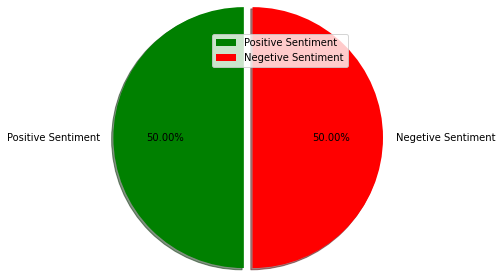

In [51]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

## 2.1) Kata Positif yang paling sering digunakan

<Figure size 3600x2400 with 0 Axes>

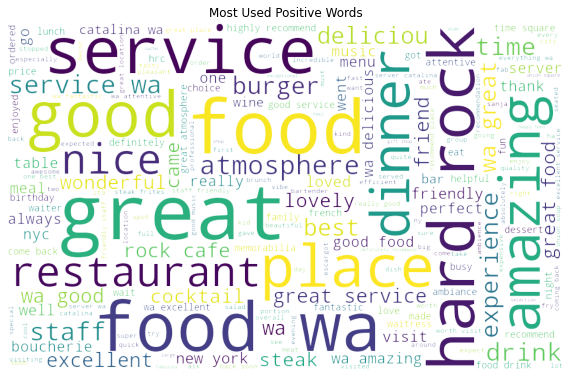

In [52]:
positive_words =' '.join([text for text in total_data['processed_review'][total_data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words")
plt.savefig('gdrive/My Drive/projekml/assets/positive_words.png')
plt.show()

## 2.2) Kata Negatif yang paling sering digunakan

<Figure size 3600x2400 with 0 Axes>

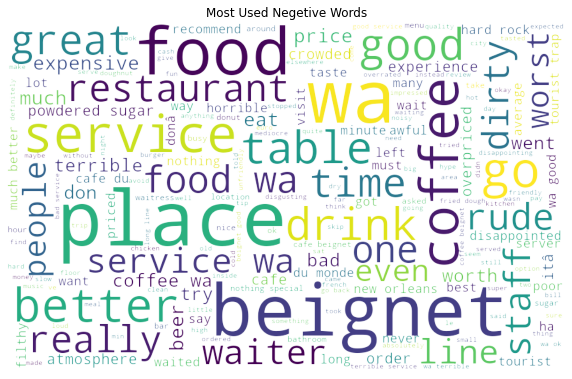

In [53]:
negetive_words =' '.join([text for text in total_data['processed_review'][total_data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, 
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negetive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negetive Words")
plt.savefig('gdrive/My Drive/projekml/assets/negetive_words.png')
plt.show()

# 3) Feature extraction (vectorization)

## 3.1) Tf-Idf vectorizer

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tf_idf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
final_vectorized_data = tf_idf_vectorizer.fit_transform(total_data['processed_review'])

final_vectorized_data

<2000x50802 sparse matrix of type '<class 'numpy.float64'>'
	with 96734 stored elements in Compressed Sparse Row format>

# 4) Splitting

##### Memisahkan data latih untuk menguji akurasi

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.1, random_state=42)  

##### menampilkan ukuran dataset yang telah dipisah

In [56]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (1800, 50802)
X_test_shape :  (200, 50802)
y_train_shape :  (1800,)
y_test_shape :  (200,)


# 5) Train dan predict

#### Menggunakan Multinomial Naive Bayes classifier

In [57]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

##### Print Confusion matrix

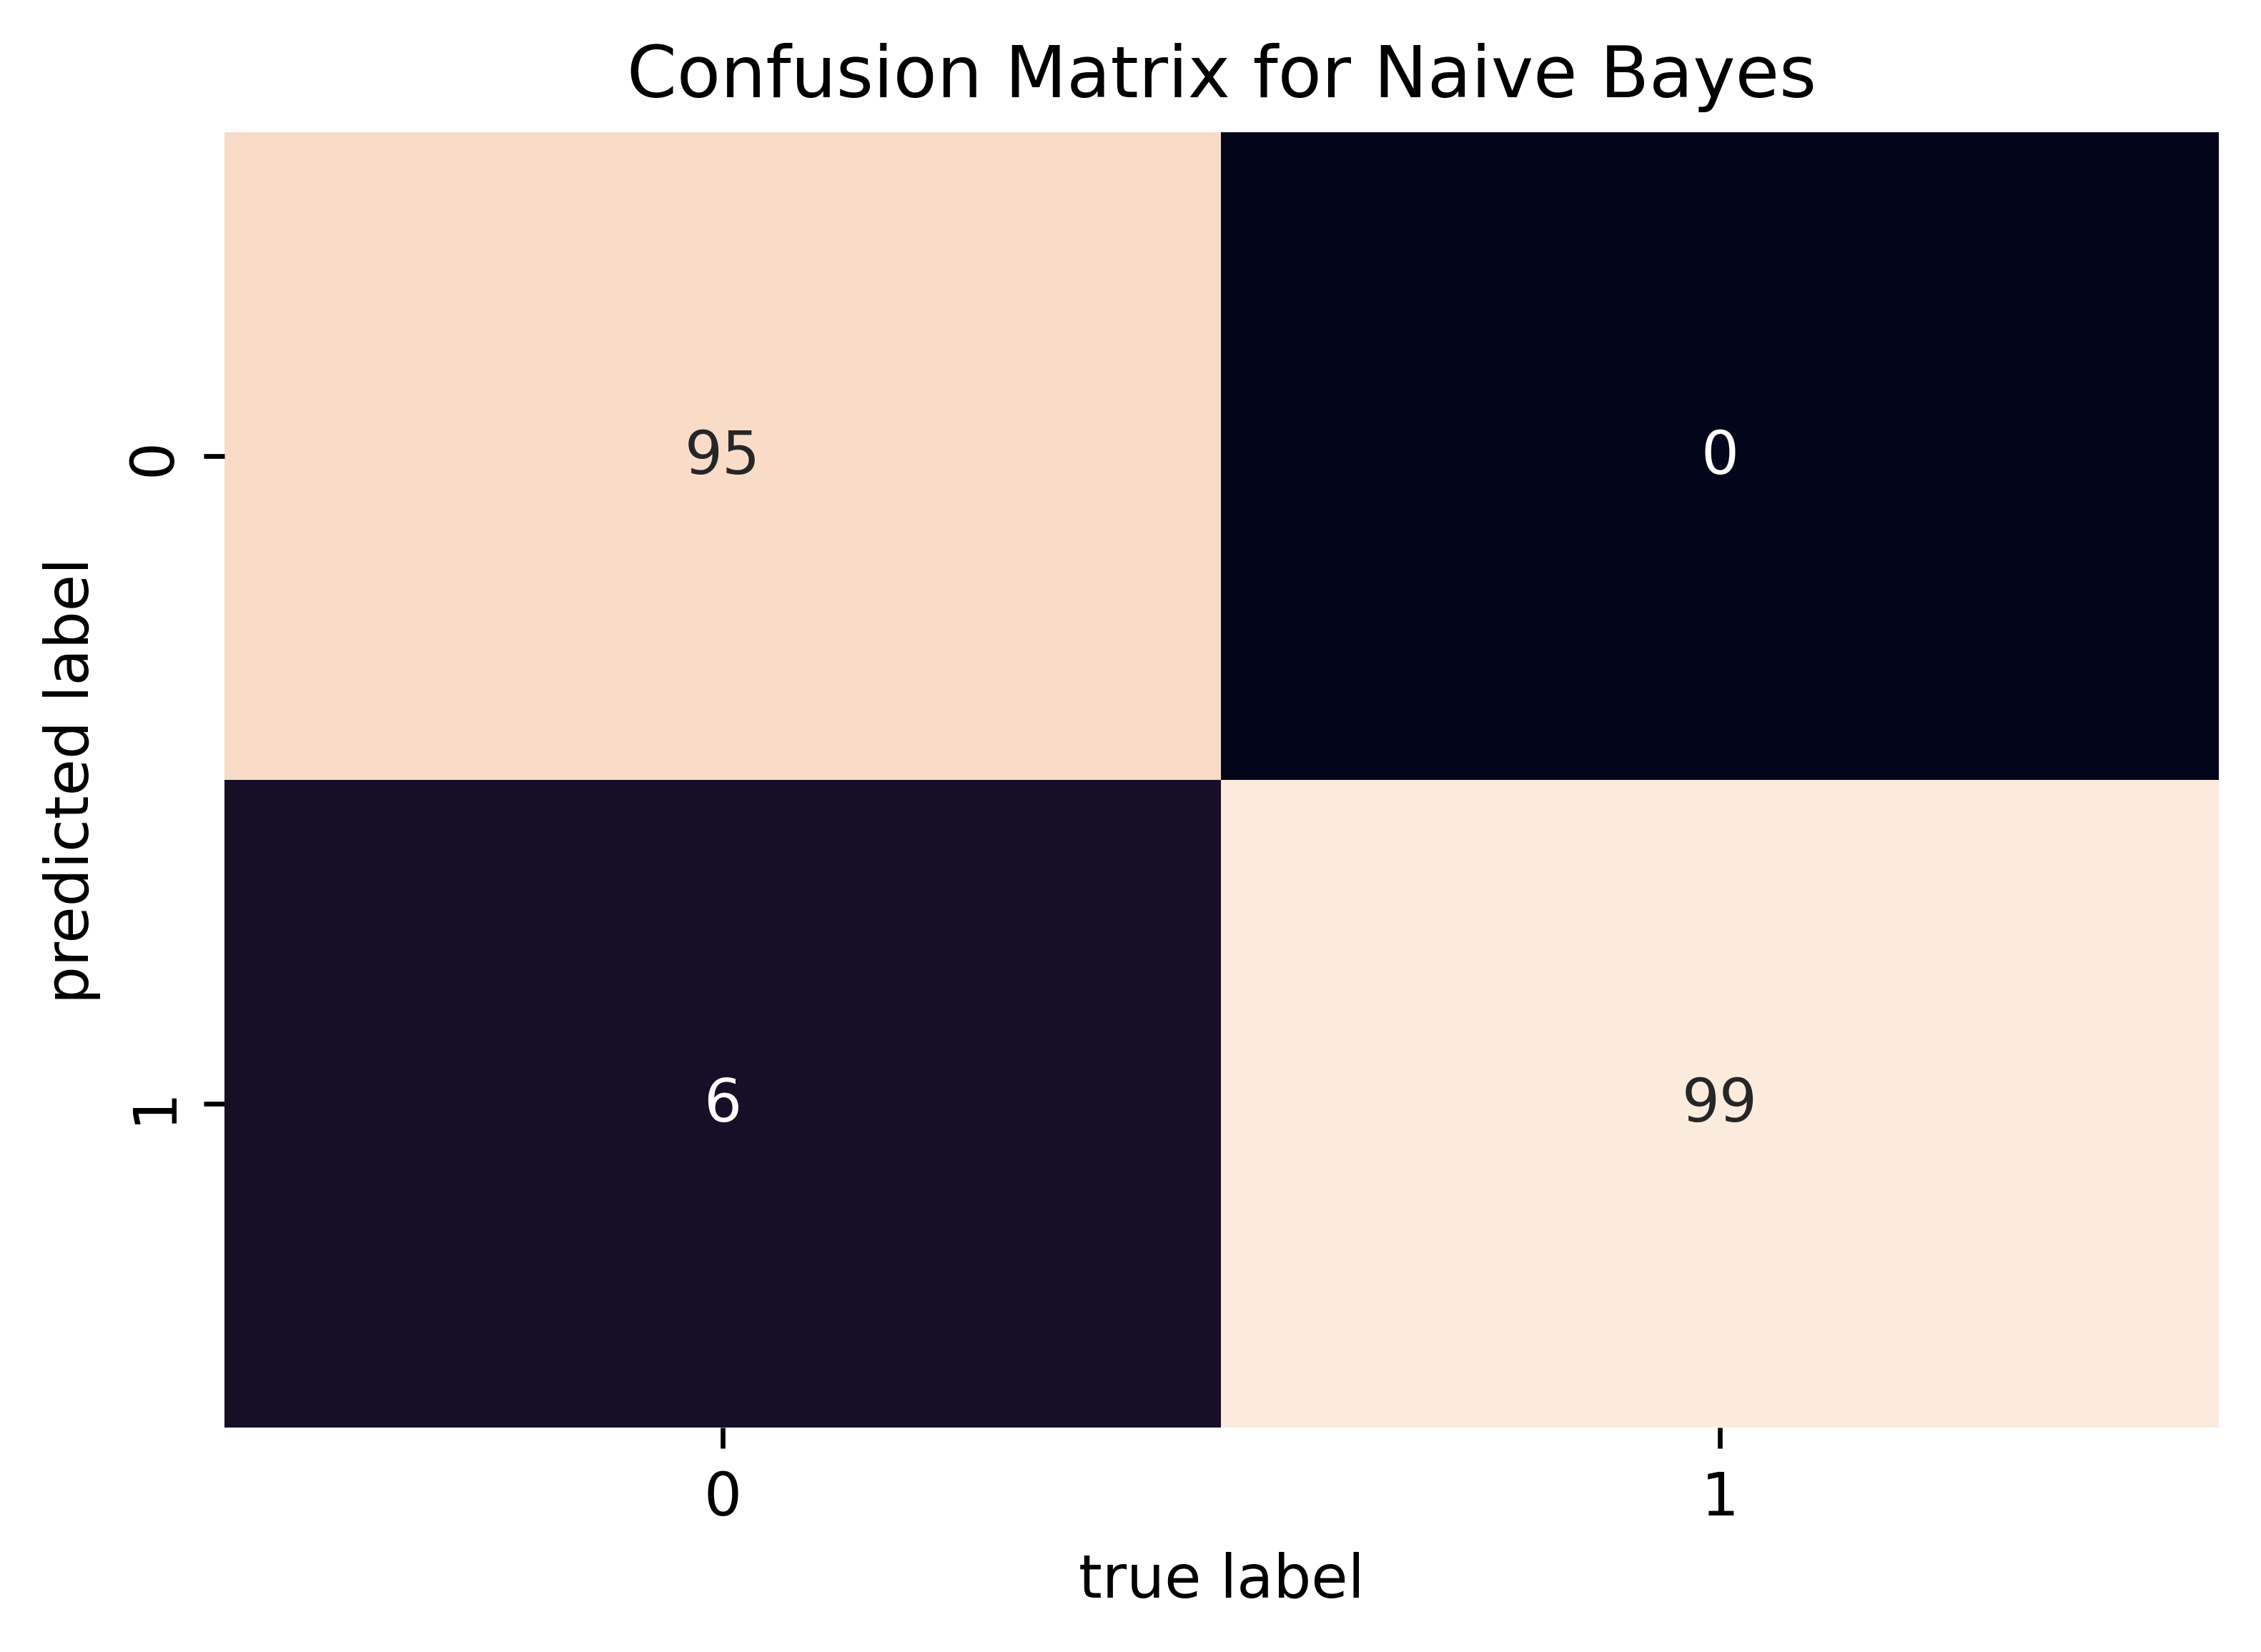

In [58]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=600)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("gdrive/My Drive/projekml/assets/confusion_matrix.png")
plt.show()

## Menampilkan akurasi dari prediksi

In [59]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy dengan Naive-bayes: ",score_naive)

Accuracy dengan Naive-bayes:  0.97


# 6) Precision, Recall, dan Accuracy

##### Precision, recall, dan accuracy adalah metrik standar yang digunakan untuk mengevaluasi kinerja pengklasifikasi..

* Precision mengukur berapa banyak teks yang diprediksi dengan benar sebagai milik kategori tertentu dari semua teks yang diprediksi (benar dan salah) sebagai milik kategori.

* Recall mengukur berapa banyak teks yang diprediksi dengan benar sebagai milik kategori tertentu dari semua teks yang seharusnya diprediksi termasuk dalam kategori tersebut. Semakin banyak data yang kita masukkan ke pengklasifikasi, semakin baik ingatannya.

* Accuracy mengukur berapa banyak teks yang diprediksi dengan benar (baik yang termasuk dalam kategori maupun yang tidak termasuk dalam kategori) dari semua teks dalam korpus.

##### Paling sering precision dan recall digunakan untuk mengukur kinerja karena akurasi saja tidak banyak menjelaskan tentang seberapa baik atau buruk pengklasifikasi.

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       101
           1       0.94      1.00      0.97        99

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



### Membuat ROC curve

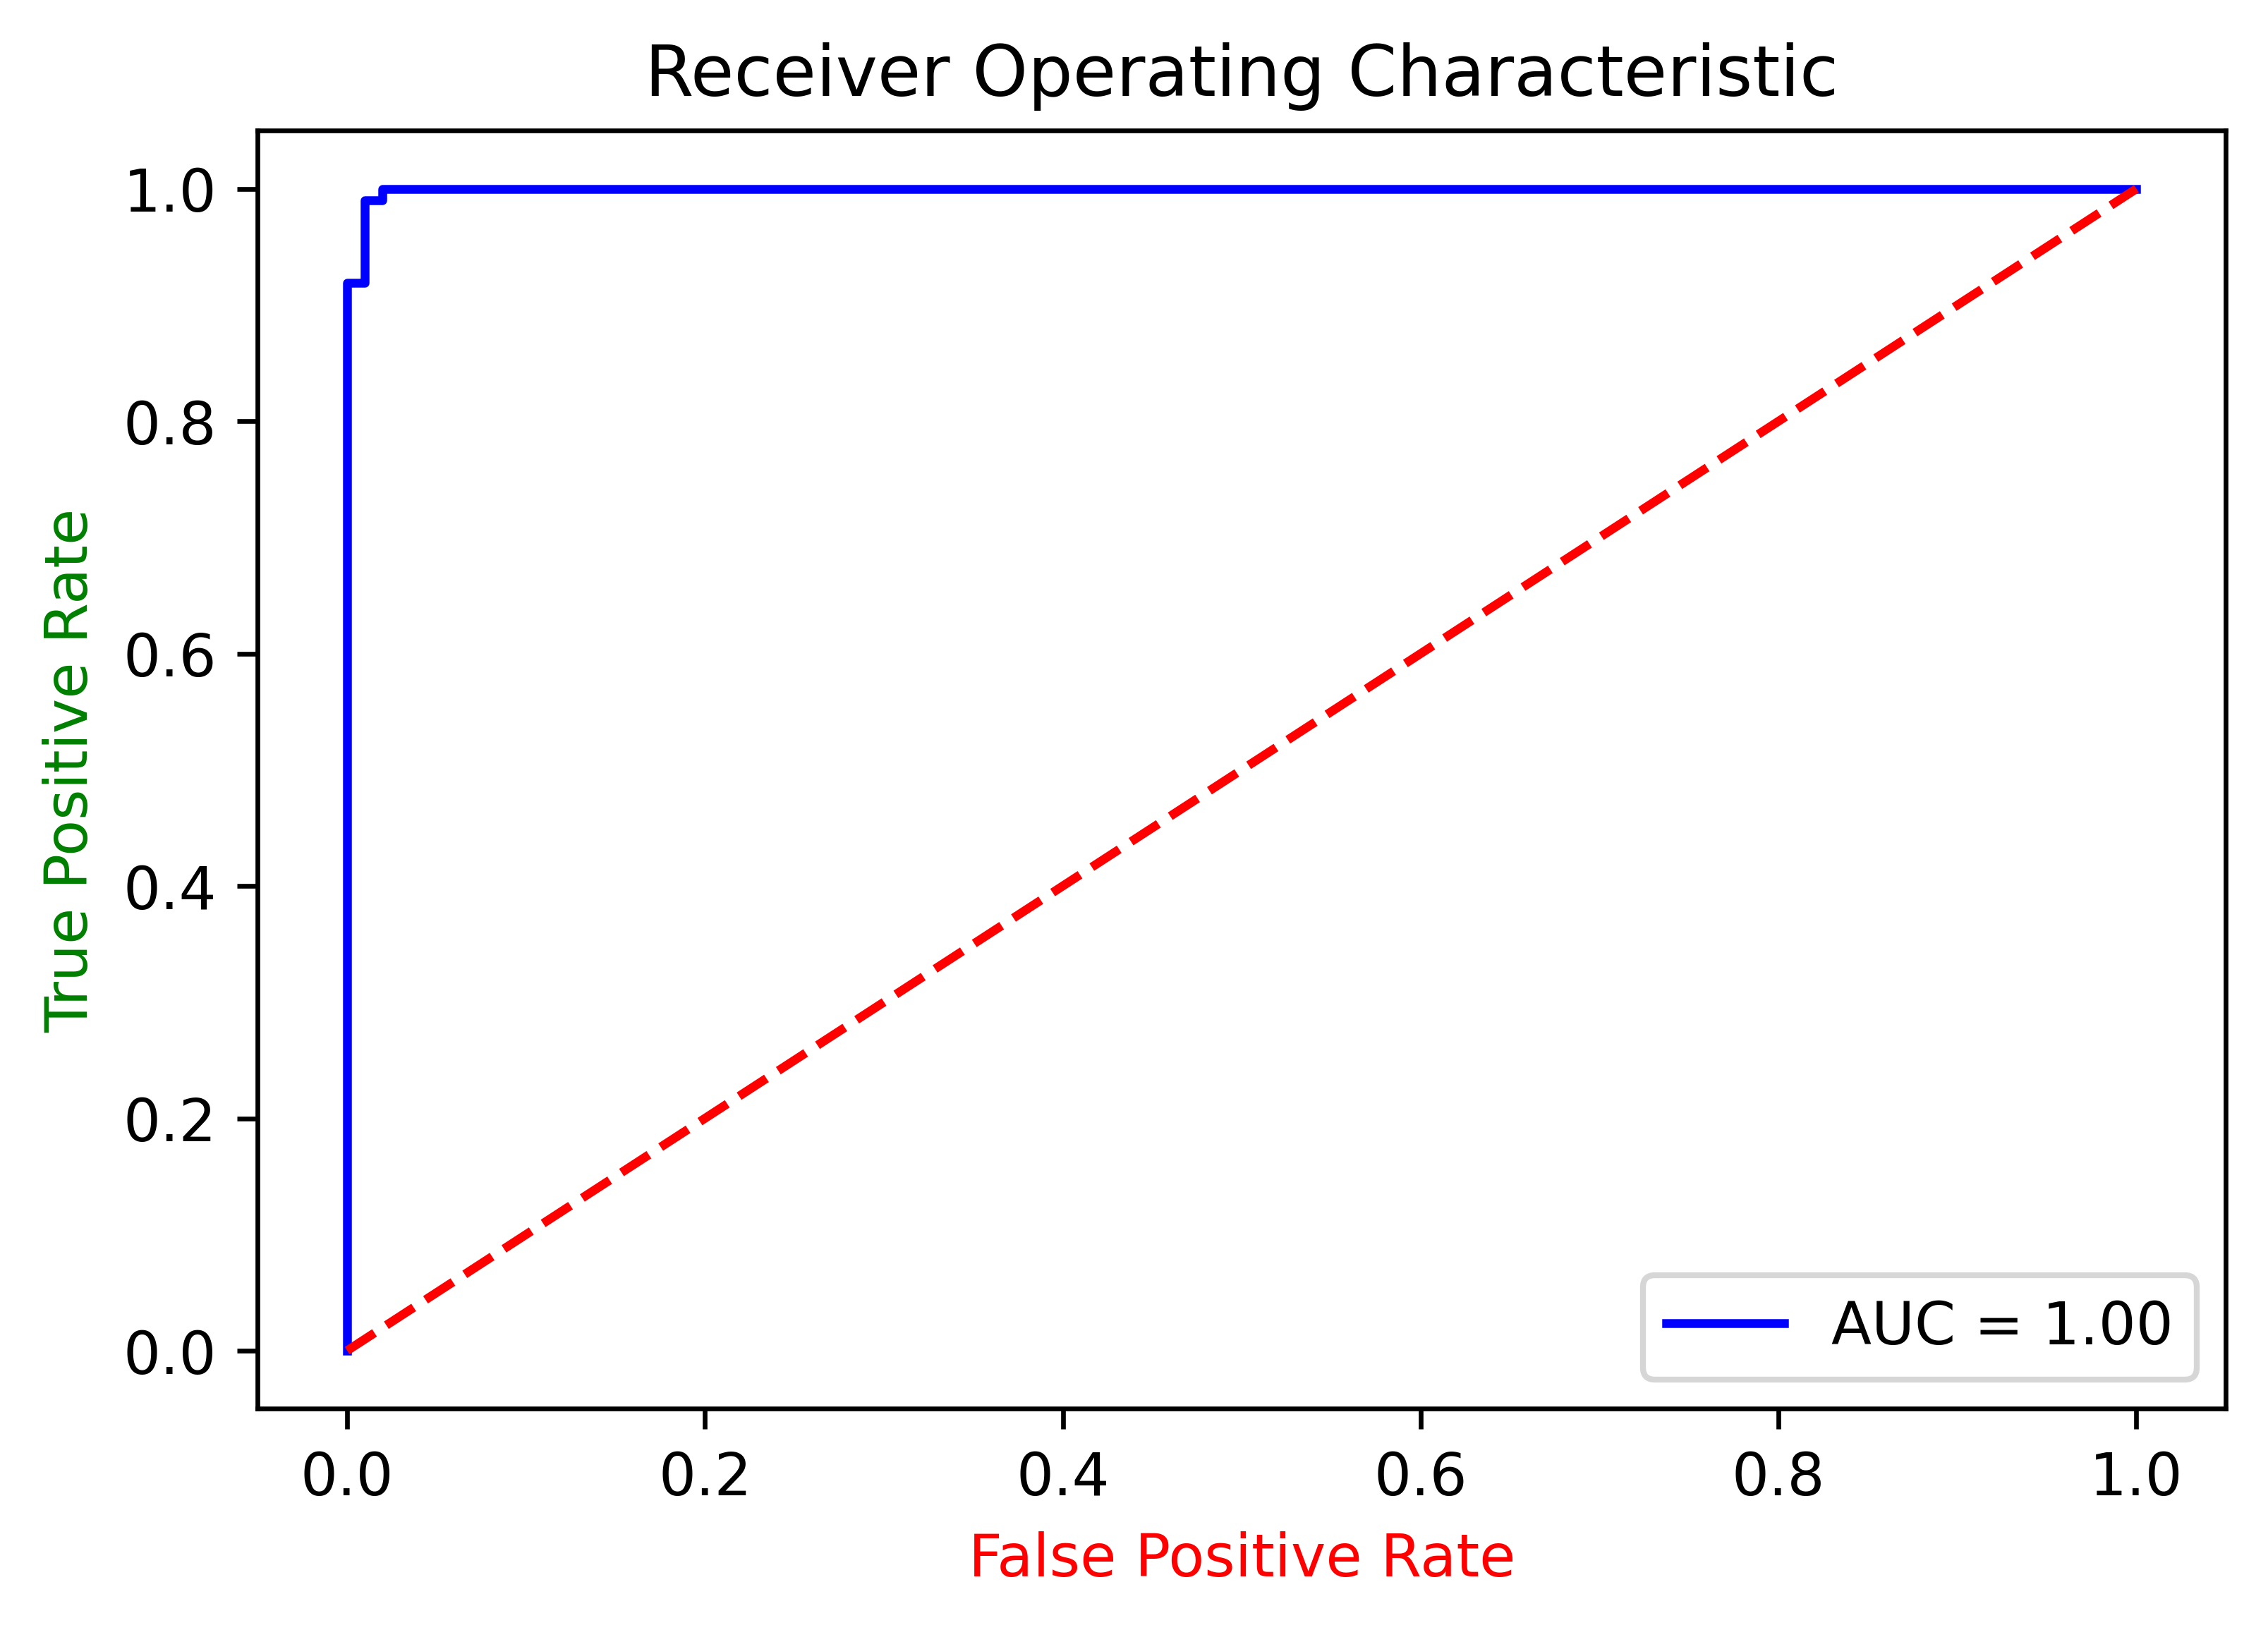

In [61]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=600)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.savefig("gdrive/My Drive/projekml/assets/ROC_curve.png")
plt.show()